In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
def getInfo(str_in):
    grouped = re.findall('"(.*)" "(.*)" "(.*)"', str_in)
    if len(grouped) == 0:
        return None
    return grouped[0]

In [4]:
def getCharacterDictFromFile(file_name):
    df = pd.read_fwf(file_name)
    lines = []
    for i in df['"character" "dialogue"']:
        lines.append(getInfo(i))
    character_dict = {}
    for line in lines:
        if line is None:
            continue
        if line[1] in character_dict:
            character_dict[line[1]].append(line)
        else :
            character_dict[line[1]] = [line]
    return character_dict

In [5]:
character_dictIV = getCharacterDictFromFile('./Transcripts/SW_EpisodeIV.txt')
character_dictV = getCharacterDictFromFile('./Transcripts/SW_EpisodeV.txt')
character_dictVI = getCharacterDictFromFile('./Transcripts/SW_EpisodeVI.txt')

In [6]:
def getCharacterTalk(character_dict):
    character_talk = {}
    for character in character_dict:
        character_talk[character] = len(character_dict[character])
    sorted_character_talk = sorted (character_talk.items(), key=lambda x: x[1], reverse=True)
    return sorted_character_talk

In [7]:
character_talkIV = getCharacterTalk(character_dictIV)    
character_talkV = getCharacterTalk(character_dictV)    
character_talkVI = getCharacterTalk(character_dictVI)    

In [70]:
def drawTalkGraph(talk):
    x = []
    y = []
    for i in talk:
        x.append(i[0])
        y.append(i[1])

    plt.figure(figsize = (20,5))
    plt.title("")
    plt.bar(x,y)
    plt.xticks(rotation=90)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    plt.show()

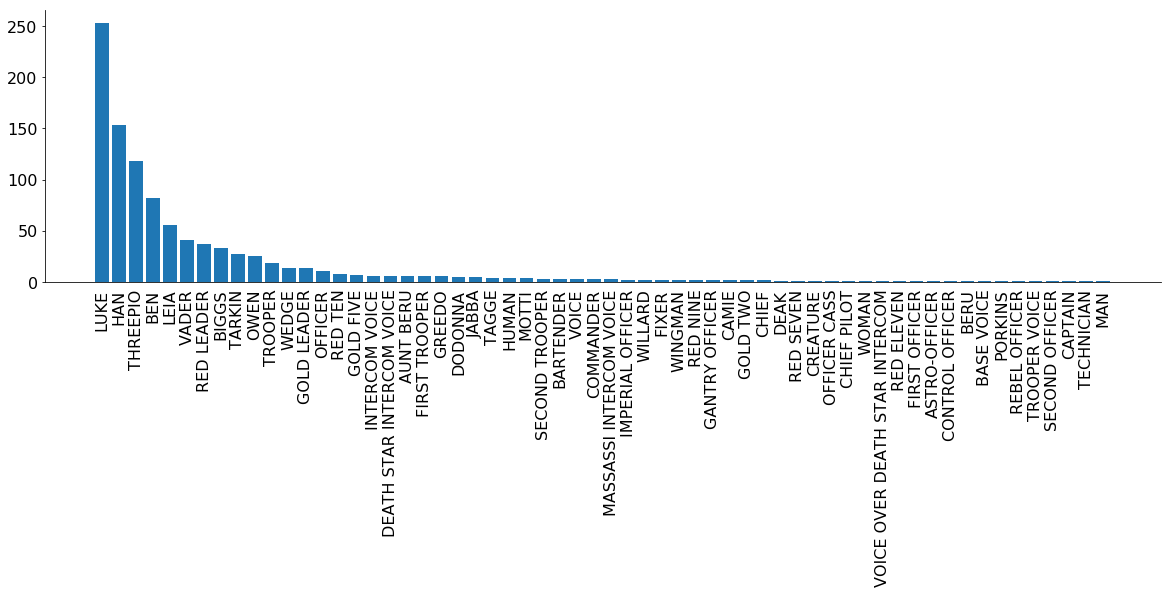

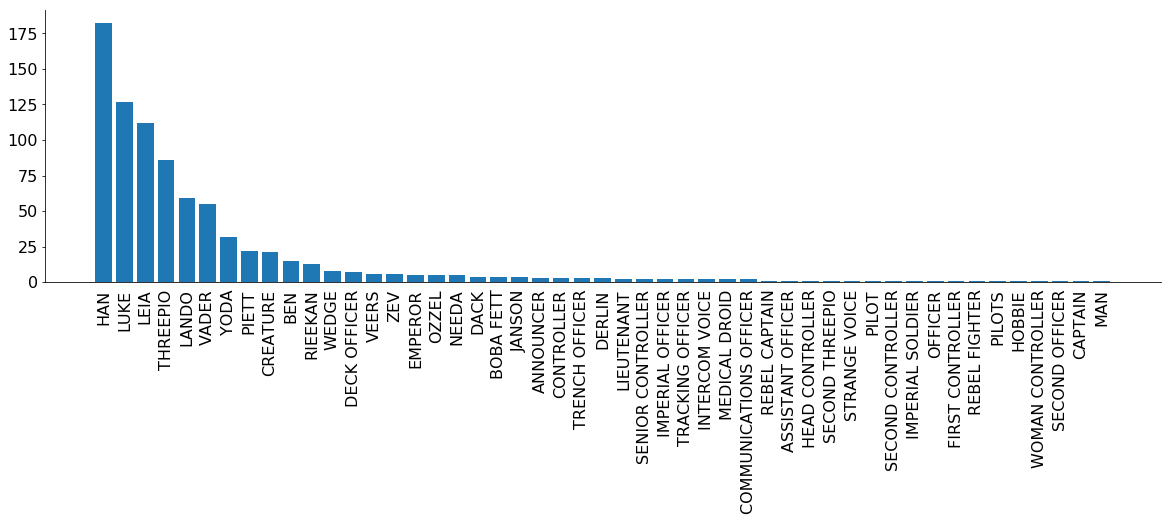

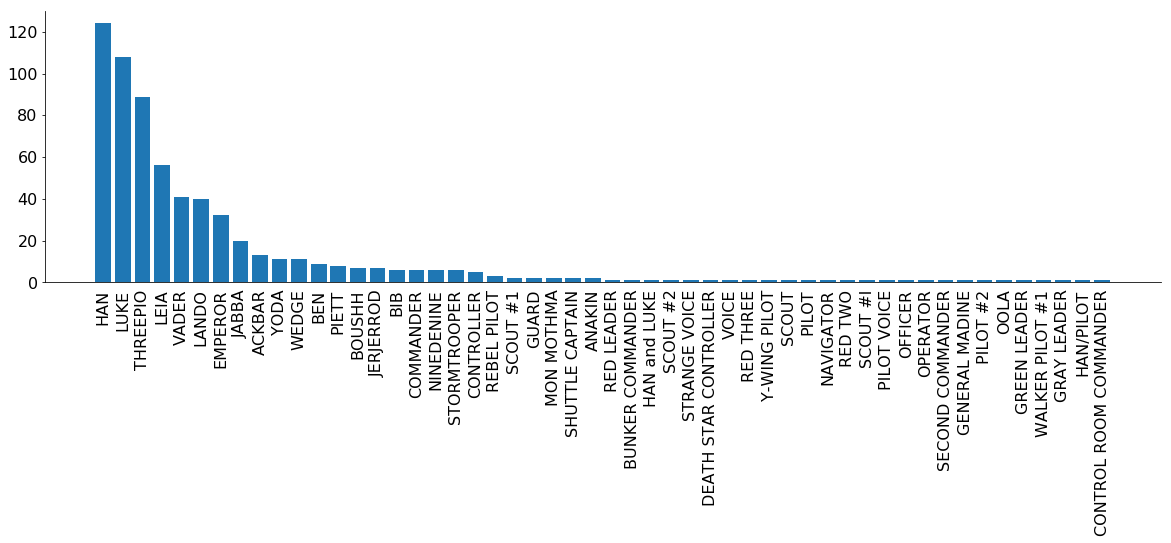

In [76]:
for i in [character_talkIV, character_talkV, character_talkVI]:
    drawTalkGraph(i)

# NLTK 

In [10]:
import nltk
import numpy as np
import io

In [11]:
def tokenize(text):
    text = text.encode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

In [12]:
def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in list
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    sentiment_sum = 0.0
    count = 0
    for token in tokens:
        if token in sentiment_dict:
            sentiment_sum += float(sentiment_dict[token]) # happiness avg
            count += 1
    if count == 0:
        return None
    avg_hap = sentiment_sum / float(count)
    return avg_hap

In [13]:
def getSentimentsForCharacter(character, character_dict):
    time = []
    sentiments = []
    if character not in character_dict:
        return None
    c = character_dict[character]
    for line in c:
        tokens = tokenize(line[2])
        sentiment = get_sentiment(tokens)
        if(sentiment) is None:
            continue
        time.append(int(line[0]))
        sentiments.append(sentiment)
    return time, sentiments

### Sentiment analysis for the heroes of a new hope
We have analysed the sentiment of the main heroes in the new hope, Han, Luke and Leia, across the movie. Through this, we are able to spot specific scenes based on the collective sentiment changes of the heroes. We have outlined the scene where Luke, Han and Leia falls into the garbage compressor on the death-star. 

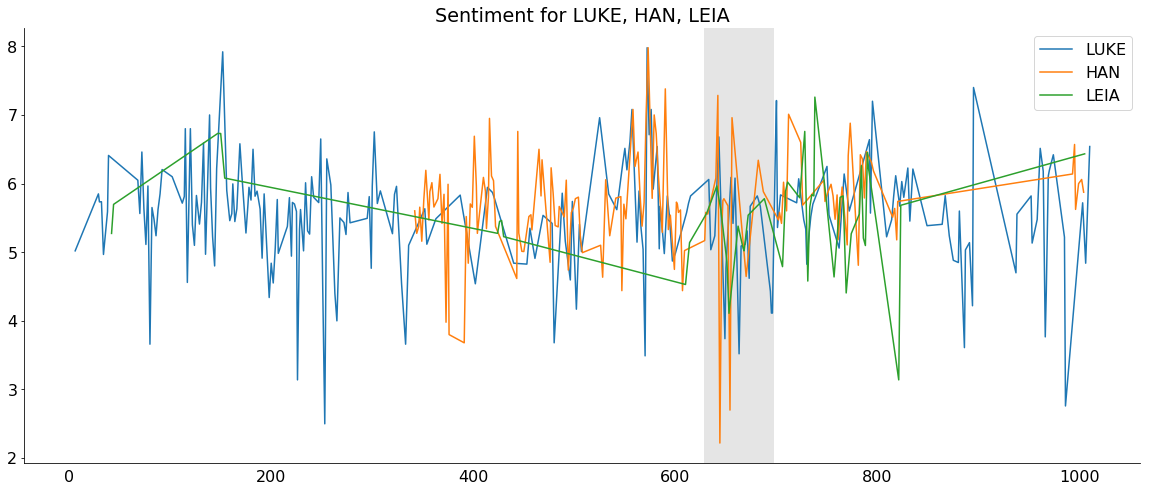

In [207]:
def drawSentimentForCharacters(chars, character_dict):
    plt.figure(figsize=(20,8))
    plt.title("Sentiment for " + ", ".join(chars))
    for char in chars:
        x, y = getSentimentsForCharacter(char, character_dict);
        plt.plot(x,y)
    plt.axvspan(628, 698, facecolor='0.5', alpha=0.2)
    plt.legend(chars)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    plt.show()
drawSentimentForCharacters(["LUKE", "HAN", "LEIA"], character_dictIV)

In [194]:
def characterSentimentAcrossMovies(char, list_of_dicts, movie_names):
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for " + char + " across the movies")
    ax1.set_ylabel("Sentiment values for "+ char)
    
    top = 0
    bottom = 100
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForCharacter(char, char_dict)[1]
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    ax1.boxplot(data)
    ax1.set_xticklabels(movie_names, rotation=60)
    
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(list_of_dicts)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(list_of_dicts)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    d1 = [i+1 for i in range(len(list_of_dicts))]
    d2 = [np.mean(a) for a in data]
    plt.plot(d1, d2, linewidth= 2.5, label="Mean")  
    plt.legend()
    plt.show()  

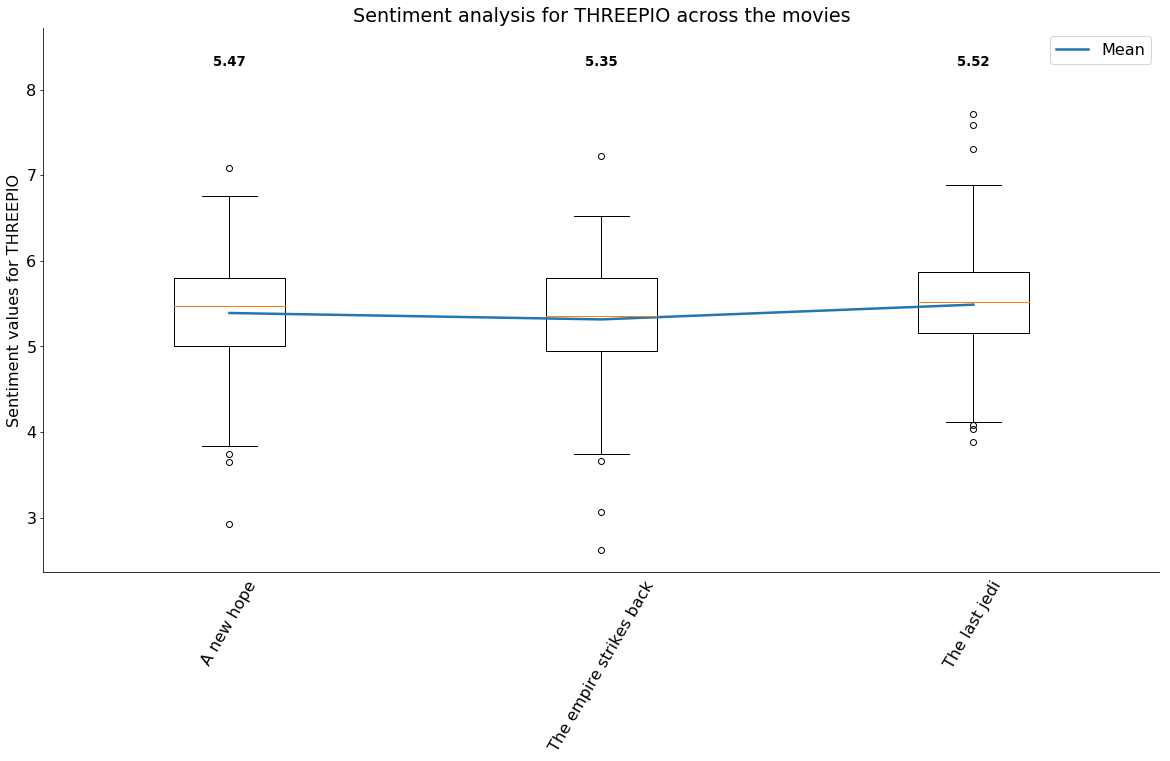

In [195]:
characterSentimentAcrossMovies("THREEPIO", [character_dictIV, character_dictV, character_dictVI], ["A new hope", "The empire strikes back", "The last jedi"])

In [17]:
def getSentimentsForMovie(character_dict):
    sentiments = []
    for char in character_dict.keys():
        character = character_dict[char]
        for line in character:
            tokens = tokenize(line[2])
            sentiment = get_sentiment(tokens)
            if sentiment is None:
                continue
            sentiments.append(sentiment)
    return sentiments

### Movie sentiment analysis
In this section we analyze the sentiment acrosse the movies. To do so we utilize the ```getSentimentsForMovie``` method to get sentiments for lines in the dialog of individual scripts. When those are derived, we simply use boxplots on those sentiment_lists to get the plots below. We also plot the mean sentiment across the entire script to see if the dialog is more positive than the rest of the scirpt.

In [72]:
def drawMovieSentiments(list_of_dicts, movie_names):
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for the Star Wars movie transcripts")
    ax1.set_ylabel("Sentiment values")
    
    hmm = [5.406530083777608, 5.44491304347826, 5.411421058398159]
    
    top = 0
    bottom = 100
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForMovie(char_dict)
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    ax1.boxplot(data)
    ax1.set_xticklabels(movie_names, rotation=60)
    
    top = top + 1
    bottom = bottom - 1
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(list_of_dicts)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(list_of_dicts)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold", color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    d1 = [i+1 for i in range(len(list_of_dicts))]
    d2 = [np.mean(a) for a in data]
    plt.plot(d1, d2, linewidth = 2.5, label = "Mean")  
    
    plt.plot(d1, hmm, linewidth=5, label="Mean of entire scripts")
    
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1), fancybox=True, shadow=True, ncol=5)
    plt.show()  

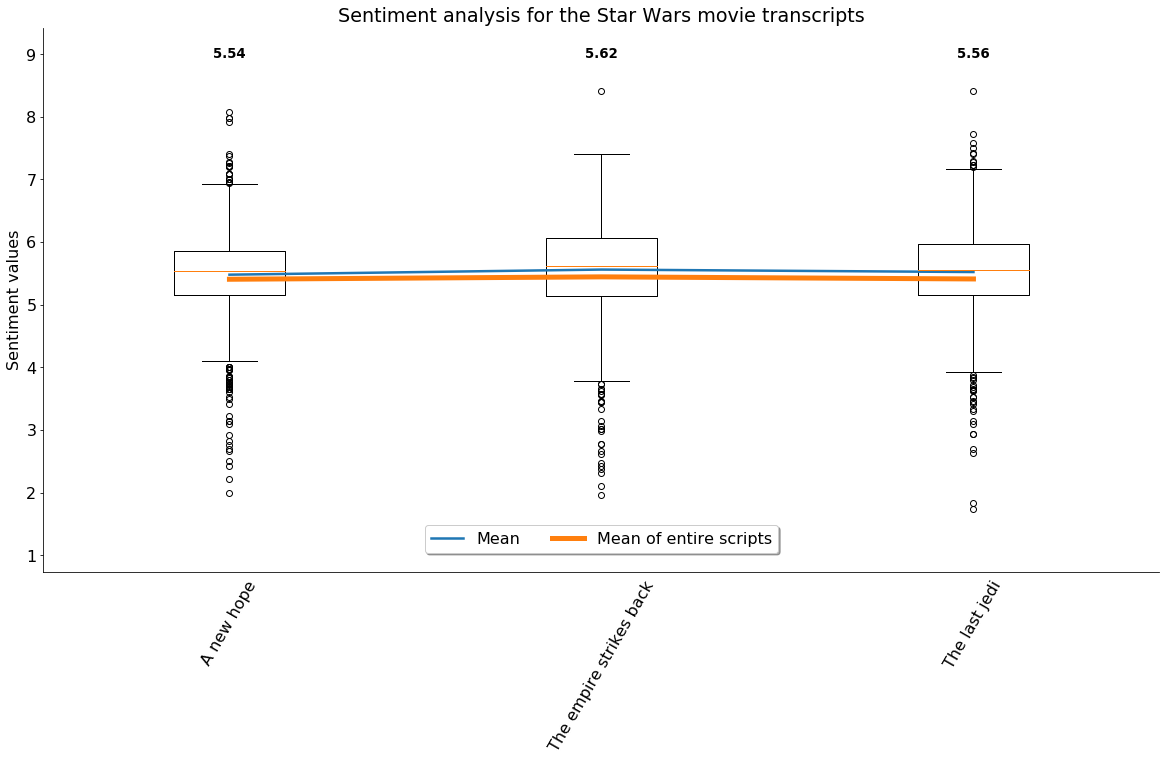

In [73]:
drawMovieSentiments([character_dictIV, character_dictV, character_dictVI], ["A new hope", "The empire strikes back", "The last jedi"])

In [20]:
def getCharacterMeanSTDSentiment(char, character_dict):
    c = getSentimentsForCharacter(char, character_dict)
    if c is None:
        return None
    return np.mean(c[1]), np.std(c[1])

def getAllCharacterMeanSTDSentiment(character_dict, only_speaking = True):
    meanSentiments = {}
    for char in character_dict:
        c = getCharacterMeanSTDSentiment(char, character_dict)
        if (c[1] > 0 or not only_speaking) and not math.isnan(c[1]):
            meanSentiments[char] = c
    return meanSentiments

def getMinMaxSentiment(character_dict, only_speaking = True):
    meanSentiments = getAllCharacterMeanSTDSentiment(character_dict, only_speaking)
    sorted_by_value = sorted(meanSentiments.items(), key=lambda kv: kv[1])   
    return sorted_by_value[0], sorted_by_value[-1]

In [65]:
minMax = [getMinMaxSentiment(i, True) for i in [character_dictIV, character_dictV, character_dictVI]]
for i in minMax:
    print("The most negative person is " + i[0][0] + " and the most positive is " + i[1][0])

The most negative person is CAMIE and the most positive is AUNT BERU
The most negative person is SENIOR CONTROLLER and the most positive is COMMUNICATIONS OFFICER
The most negative person is COMMANDER and the most positive is NINEDENINE


In [121]:
def getLinesContainingTerm(character_dict, term):
    lines = []
    for char in character_dict.keys():
        character = character_dict[char]
        for line in character:
            if term in line[2].lower():
                lines.append(line[2].lower())
    return lines

In [179]:
def getTermSentiment(character_dict, term):
    lines = getLinesContainingTerm(character_dict, term)
    sentiment = []
    if not lines:
        return 0, 0
    for line in lines:
        tokens = tokenize(line)
        senti = get_sentiment(tokens)
        if senti:
            sentiment.append(senti)
    return sentiment, np.mean(sentiment), np.std(sentiment)

In [202]:
def getNameSentiments(character_dict):
    sentiment_names = []
    for name in character_dict.keys():
        if name == "BERU":
            continue
        tupl = (name, getTermSentiment(character_dictIV, name.lower()))
        if tupl[1][1] > 0:
            sentiment_names.append( tupl)   
            
    sorted_sentiment_names = sorted (sentiment_names, key=lambda x: x[1][1], reverse=True)

    return sorted_sentiment_names

In [205]:
def drawNameSentiments(character_dict):
    fig, ax1 = plt.subplots(figsize=(20, 8))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for characternames based on dialog")
    ax1.set_ylabel("Sentiment values")
    
    top = 0
    bottom = 100
    data = [] 
    names = []
    
    dat = getNameSentiments(character_dict)
    for i in dat:
        data.append(i[1][0])
        names.append(i[0])
        if top < max(data[-1]):
            top = max(data[-1])
        if bottom > min(data[-1]):
            bottom = min(data[-1])
        
    ax1.boxplot(data)
    ax1.set_xticklabels(names, rotation=90)
    
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(names)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(names)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    plt.show()  

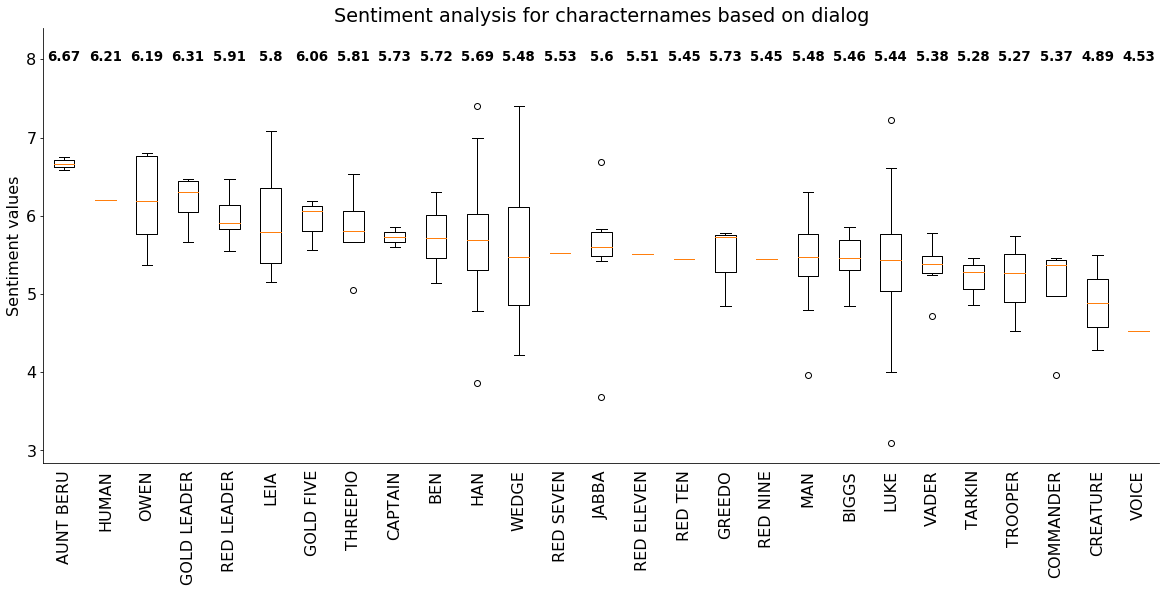

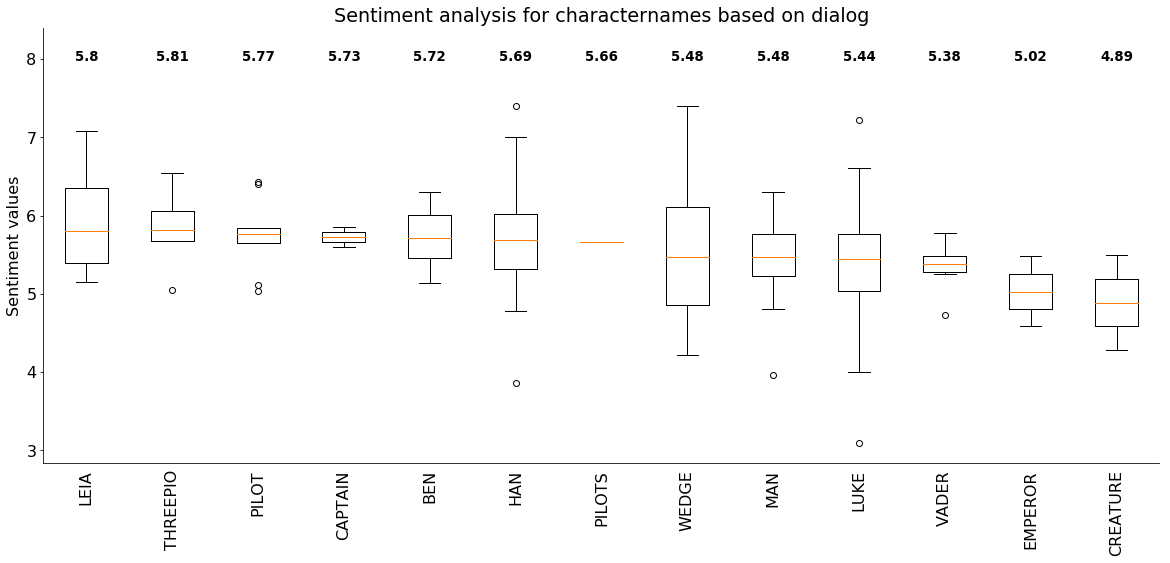

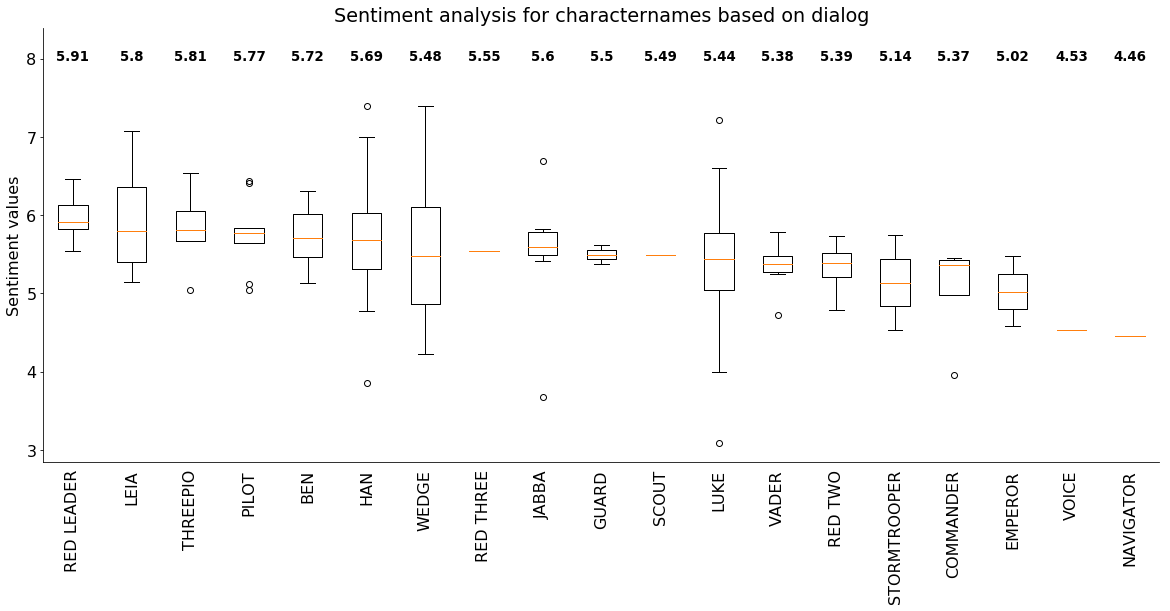

In [206]:
drawNameSentiments(character_dictIV)
drawNameSentiments(character_dictV)
drawNameSentiments(character_dictVI)

# Word clouds

In [22]:
from wordcloud import WordCloud
import math
from PIL import Image
from os import path

### TF - IDF

#### TF:
\\[ tf(t,d) = \dfrac{f_{t, d}}{\mid d_u \mid} \qquad f_{t,d} = \text{the frequency of t in d} \qquad d_u = \text{Unique words in d} \\]

#### IDF:
\\[ idf(term, documents) = \log \left( \dfrac{N}{\mid \left\{ document \in documents : term \in document \right\} \mid}  \right) \\]

#### TF-IDF:
\\[ tf-idf(t, d, D) = tf(t, d) \cdot idf(t, D) \\]

In [101]:
def tf_idf(doc1, docs):
    # TF
    fd = nltk.FreqDist(doc1)
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([(float(x[1])/len(fd)) for x in fd.most_common()])

    # IDF
    dem_sets = [set(doc1)]
    for doc in docs:
        dem_sets.append(set(doc))
       
    df = np.array([sum([t in s for s in dem_sets]) for t in sorted_tokens])    
    idf = np.log((len(docs)+1) / df)
    
    tf_dict = {}
    for i in range(len(sorted_tokens)):
        tf_dict[sorted_tokens[i]] = tf[i] * idf[i]

        return tf_dict

In [102]:
def oneLiner(character_dict):
    one_list_to_rule_them_all = []
    for char in character_dict:
        for line in character_dict[char]:
            one_list_to_rule_them_all.append(line[2])
    return " ".join(one_list_to_rule_them_all)

In [103]:
textIV = oneLiner(character_dictIV)
textV = oneLiner(character_dictV)
textVI = oneLiner(character_dictVI)

In [104]:
def generate_wordcloud(doc, docs):
    doc_tokens = tokenize(doc)
    docs_tokens = tokenize(" ".join(docs))
    tfidf = tf_idf(doc_tokens, docs_tokens)
    
    r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
    wordcloud = WordCloud(background_color="white", max_words=2000, mask=r2_mask)

    wordcloud.generate_from_frequencies(tfidf)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

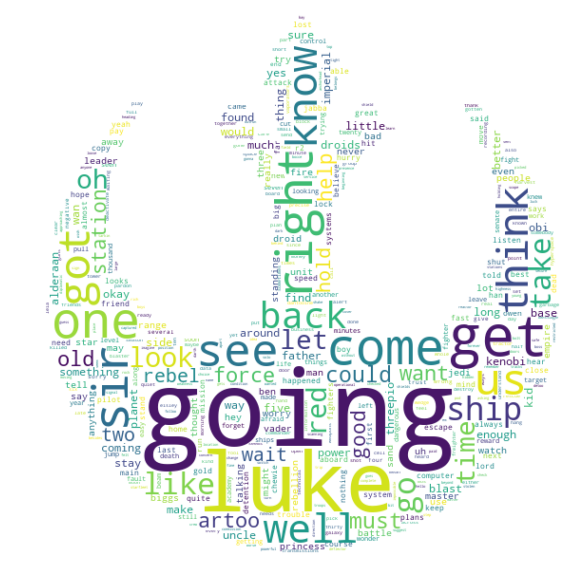

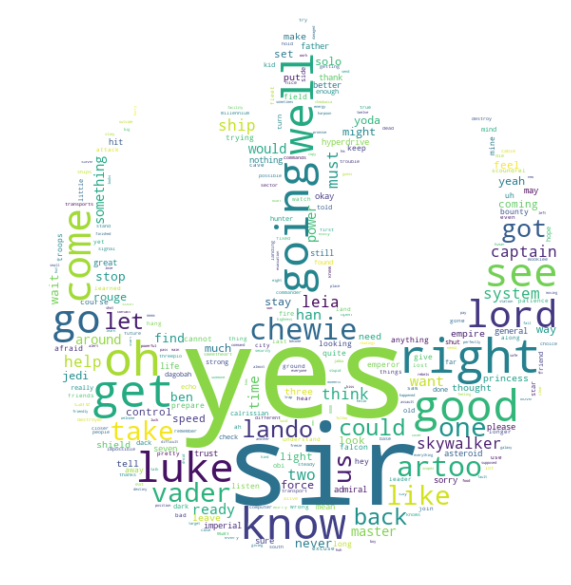

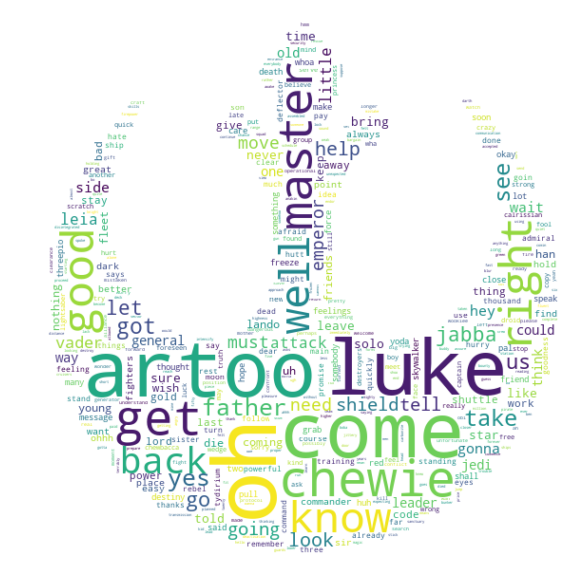

In [106]:
generate_wordcloud(textIV, [ textV, textVI])
generate_wordcloud(textV, [textIV, textVI])
generate_wordcloud(textVI, [textIV, textV])